In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [22]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_train.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_test.csv"
test_data = pd.read_csv(test_data_path)

In [23]:
keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']

data_classification = data.copy()
test_classification = test_data.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)

In [24]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification[['loan_status']]

In [25]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc

from sklearn.utils import shuffle

results_summary = []

def method_evaluation(model, data_x, data_y, X_test, y_test, method):
    print(f"Preprocessing method : {method}")

    if method == 'Base':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y)

        model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        verbose=True
        )

        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)

    elif method == 'Undersampling':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.13, stratify=data_y)
        undersampler = RandomUnderSampler()
        X_under, y_under = undersampler.fit_resample(X_train, y_train)

        data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)
        X_train = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
        y_train = data_under[['loan_status']]  # Target (타겟 변수)

        model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)

    elif method == 'SMOTE':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.33, stratify=data_y)

        smote = SMOTE()

        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        augmentation_data = pd.concat([X_train_smote, y_train_smote], axis = 1)
        X_train = augmentation_data.drop(columns='loan_status')
        y_train = augmentation_data[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'table-gan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/return_feature/return_feature_OI_11_00_fake.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1
        
        keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)

        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.33, stratify=data_y)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total, random_state=42)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)

    elif method == 'Smotified-gan':
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/smotified_fake_data.csv"
        fake = pd.read_csv(fake_path)

        #keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv']
        fake_Classification = fake.copy()
        #fake_Classification = fake_Classification.drop(columns = keep_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    

    precision_0 = precision_score(y_test, y_pred, pos_label=0)
    recall_0 = recall_score(y_test, y_pred, pos_label=0)
    f1_0 = f1_score(y_test, y_pred, pos_label=0)

    precision_1 = precision_score(y_test, y_pred, pos_label=1)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    f1_1 = f1_score(y_test, y_pred, pos_label=1)

    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    au_prc = auc(recall, precision)

    results_summary.append({
    'Method': method,
    'Recall_0': recall_0,
    'Precision_0': precision_0,
    'F1_0': f1_0,
    'Recall_1': recall_1,
    'Precision_1': precision_1,
    'F1_1': f1_1,
    'AU_PRC': au_prc,
    'y_prob': y_prob,
    'y_test': y_test.squeeze()  
    })

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from tqdm import tqdm

Methods = ['Base', 'Undersampling', 'SMOTE', 'table-gan','Smotified-gan']
n_runs = 250

all_results = []

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification['loan_status']

for method in Methods:
    print(f"\n===== {method} 시작 =====")
    
    method_results = []

    for run in tqdm(range(n_runs), desc=f'{method} Repeats'):
        data_x = data_classification.drop(columns='loan_status')
        data_y = data_classification['loan_status']

        model = XGBClassifier(
            n_estimators=500,
            learning_rate=0.01,
            objective='binary:logistic',
            eval_metric="logloss",
            verbosity=0
        )

        method_evaluation(model, data_x, data_y, X_test, y_test, method)

        last_result = results_summary[-1]  # 방금 추가된 결과만 가져옴
        method_results.append(last_result)

    all_results.append((method, method_results))


===== Base 시작 =====


Base Repeats:   0%|          | 0/250 [00:00<?, ?it/s]

Preprocessing method : Base
[0]	validation_0-logloss:0.49199	validation_1-logloss:0.49202
[1]	validation_0-logloss:0.48743	validation_1-logloss:0.48749
[2]	validation_0-logloss:0.48299	validation_1-logloss:0.48307
[3]	validation_0-logloss:0.47866	validation_1-logloss:0.47878
[4]	validation_0-logloss:0.47445	validation_1-logloss:0.47459
[5]	validation_0-logloss:0.47035	validation_1-logloss:0.47051
[6]	validation_0-logloss:0.46634	validation_1-logloss:0.46653
[7]	validation_0-logloss:0.46244	validation_1-logloss:0.46266
[8]	validation_0-logloss:0.45863	validation_1-logloss:0.45887
[9]	validation_0-logloss:0.45490	validation_1-logloss:0.45518
[10]	validation_0-logloss:0.45127	validation_1-logloss:0.45157
[11]	validation_0-logloss:0.44772	validation_1-logloss:0.44804
[12]	validation_0-logloss:0.44425	validation_1-logloss:0.44459
[13]	validation_0-logloss:0.44085	validation_1-logloss:0.44122
[14]	validation_0-logloss:0.43753	validation_1-logloss:0.43793
[15]	validation_0-logloss:0.43428	val

In [ ]:
summary_stats = []

for method, results in all_results:
    df = pd.DataFrame(results)

    summary_stats.append({
        'Method': method,
        'Recall_1_Mean': df['Recall_1'].mean(),
        'Recall_1_Std': df['Recall_1'].std(),
        'F1_1_Mean': df['F1_1'].mean(),
        'F1_1_Std': df['F1_1'].std(),
        'AU_PRC_Mean': df['AU_PRC'].mean(),
        'AU_PRC_Std': df['AU_PRC'].std(),
    })

stats_df = pd.DataFrame(summary_stats)
print(stats_df)

          Method  Recall_1_Mean  Recall_1_Std  F1_1_Mean  F1_1_Std  \
0           Base       0.747442      0.000585   0.740120  0.000199   
1  Undersampling       0.906112      0.000412   0.729781  0.000298   
2          SMOTE       0.861321      0.001393   0.743867  0.000300   
3      table-gan       0.854741      0.000556   0.723565  0.000201   
4  Smotified-gan       0.877289      0.001139   0.735847  0.000292   

   AU_PRC_Mean  AU_PRC_Std  
0     0.785931    0.000153  
1     0.783593    0.000277  
2     0.761566    0.000667  
3     0.702821    0.000469  
4     0.740267    0.000638  


In [ ]:
stats_df_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
stats_df.to_csv(path_or_buf=stats_df_path+"evaluation_100_each_method.csv", index=False)

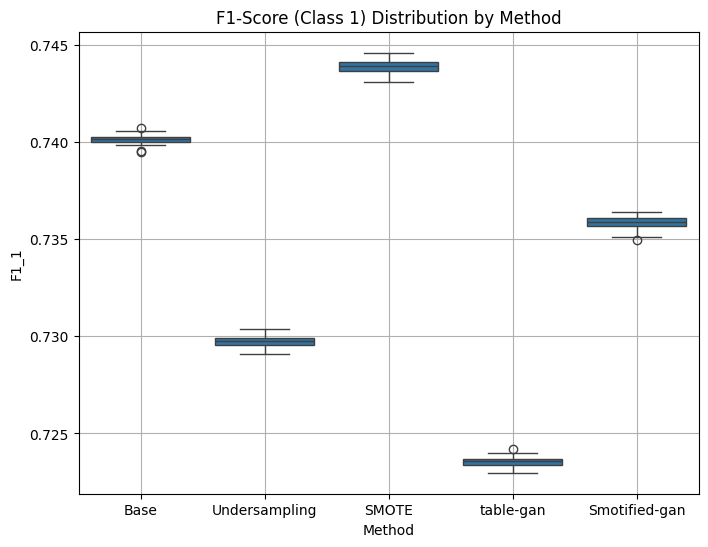

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
all_f1_df = pd.concat([
    pd.DataFrame({'Method': method, 'F1_1': [r['F1_1'] for r in results]})
    for method, results in all_results
])

sns.boxplot(data=all_f1_df, x='Method', y='F1_1')
plt.title('F1-Score (Class 1) Distribution by Method')
plt.grid(True)
plt.show()


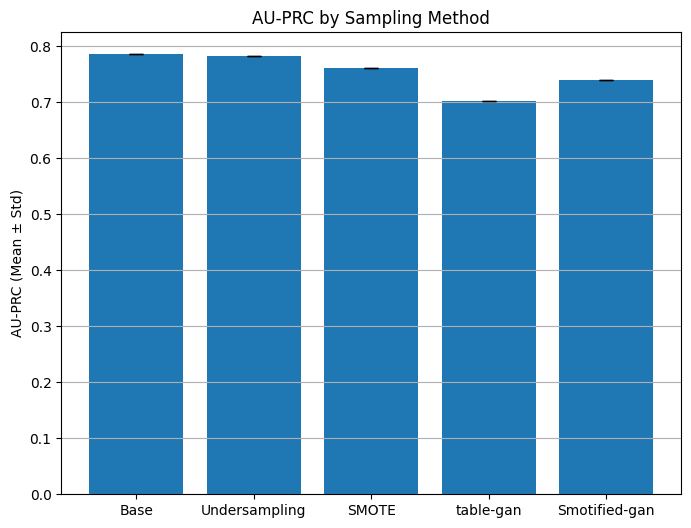

In [ ]:
plt.figure(figsize=(8, 6))
x = stats_df['Method']
y = stats_df['AU_PRC_Mean']
err = stats_df['AU_PRC_Std']

plt.bar(x, y, yerr=err, capsize=5)
plt.ylabel('AU-PRC (Mean ± Std)')
plt.title('AU-PRC by Sampling Method')
plt.grid(axis='y')
plt.show()


In [20]:
print(stats_df)

          Method  Recall_1_Mean  Recall_1_Std  F1_1_Mean  F1_1_Std  \
0           Base       0.747442      0.000585   0.740120  0.000199   
1  Undersampling       0.906112      0.000412   0.729781  0.000298   
2          SMOTE       0.861321      0.001393   0.743867  0.000300   
3      table-gan       0.854741      0.000556   0.723565  0.000201   
4  Smotified-gan       0.877289      0.001139   0.735847  0.000292   

   AU_PRC_Mean  AU_PRC_Std  
0     0.785931    0.000153  
1     0.783593    0.000277  
2     0.761566    0.000667  
3     0.702821    0.000469  
4     0.740267    0.000638  
